In [1]:
import argparse
parser = argparse.ArgumentParser()
# for training
parser.add_argument('--model_path', type=str, default='/media/arclabdl1/HD1/YLmiao/results/KMPnet_res/',help='path for saving trained models')
parser.add_argument('--model_dir', type=str, default='/media/arclabdl1/HD1/YLmiao/results/KMPnet_res/',help='path for saving trained models')
parser.add_argument('--no_env', type=int, default=100,help='directory for obstacle images')
parser.add_argument('--no_motion_paths', type=int,default=4000,help='number of optimal paths in each environment')
parser.add_argument('--no_val_paths', type=int,default=50,help='number of optimal paths in each environment')
parser.add_argument('--num_steps', type=int, default=20)


parser.add_argument('--seen_N', type=int, default=1)
parser.add_argument('--seen_NP', type=int, default=1)
parser.add_argument('--seen_s', type=int, default=0)
parser.add_argument('--seen_sp', type=int, default=800)


# Model parameters
parser.add_argument('--total_input_size', type=int, default=8, help='dimension of total input')
parser.add_argument('--AE_input_size', type=int, default=32, help='dimension of input to AE')
parser.add_argument('--mlp_input_size', type=int , default=136, help='dimension of the input vector')
parser.add_argument('--output_size', type=int , default=1, help='dimension of the input vector')

parser.add_argument('--learning_rate', type=float, default=0.01)
parser.add_argument('--seen', type=int, default=0, help='seen or unseen? 0 for seen, 1 for unseen')
parser.add_argument('--device', type=int, default=0, help='cuda device')

parser.add_argument('--num_epochs', type=int, default=500)
parser.add_argument('--batch_size', type=int, default=100, help='rehersal on how many data (not path)')
parser.add_argument('--path_folder', type=str, default='./data/acrobot_obs/')
parser.add_argument('--path_file', type=str, default='path.pkl')

parser.add_argument('--start_epoch', type=int, default=1200)
parser.add_argument('--env_type', type=str, default='acrobot_obs', help='environment')
parser.add_argument('--world_size', nargs='+', type=float, default=[3.141592653589793, 3.141592653589793, 6.0, 6.0], help='boundary of world')
parser.add_argument('--opt', type=str, default='Adagrad')
parser.add_argument('--direction', type=int, default=0, help='0: forward, 1: backward')
#parser.add_argument('--opt', type=str, default='Adagrad')
args = parser.parse_args('')
print(args)


Namespace(AE_input_size=32, batch_size=100, device=0, direction=0, env_type='acrobot_obs', learning_rate=0.01, mlp_input_size=136, model_dir='/media/arclabdl1/HD1/YLmiao/results/KMPnet_res/', model_path='/media/arclabdl1/HD1/YLmiao/results/KMPnet_res/', no_env=100, no_motion_paths=4000, no_val_paths=50, num_epochs=500, num_steps=20, opt='Adagrad', output_size=1, path_file='path.pkl', path_folder='./data/acrobot_obs/', seen=0, seen_N=1, seen_NP=1, seen_s=0, seen_sp=800, start_epoch=1200, total_input_size=8, world_size=[3.141592653589793, 3.141592653589793, 6.0, 6.0])


In [2]:
"""
This implements the Kinodynamic Planning using MPNet, by using MPNet
to generate random samples, that will guide the SST algorithm.
"""
import sys
sys.path.append('deps/sparse_rrt')
sys.path.append('.')
import torch
import model.AE.identity as cae_identity
from model.mlp import MLP
from model import mlp_acrobot
from model.AE import CAE_acrobot_voxel_2d, CAE_acrobot_voxel_2d_2, CAE_acrobot_voxel_2d_3
from model.mpnet import KMPNet
from tools import data_loader
from tools.utility import *
from plan_utility import cart_pole, cart_pole_obs, pendulum, acrobot_obs

import numpy as np
import random
import os
from sparse_rrt import _sst_module

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import random




#global hl
if torch.cuda.is_available():
    torch.cuda.set_device(args.device)
# environment setting
cae = cae_identity
mlp = MLP
cpp_propagator = _sst_module.SystemPropagator()
if args.env_type == 'pendulum':
    normalize = pendulum.normalize
    unnormalize = pendulum.unnormalize
    system = standard_cpp_systems.PSOPTPendulum()
    dynamics = None
    enforce_bounds = None
    step_sz = 0.002
    num_steps = 20

elif args.env_type == 'cartpole':
    normalize = cart_pole.normalize
    unnormalize = cart_pole.unnormalize
    dynamics = cartpole.dynamics
    system = _sst_module.CartPole()
    enforce_bounds = cartpole.enforce_bounds
    step_sz = 0.002
    num_steps = 20
elif args.env_type == 'cartpole_obs':
    normalize = cart_pole_obs.normalize
    unnormalize = cart_pole_obs.unnormalize
    system = _sst_module.CartPole()
    dynamics = cartpole.dynamics
    enforce_bounds = cartpole.enforce_bounds
    step_sz = 0.002
    num_steps = 20
elif args.env_type == 'acrobot_obs':
    normalize = acrobot_obs.normalize
    unnormalize = acrobot_obs.unnormalize
    system = _sst_module.PSOPTAcrobot()
    mlp = mlp_acrobot.MLP
    cae = CAE_acrobot_voxel_2d
    #dynamics = acrobot_obs.dynamics
    dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)
    enforce_bounds = acrobot_obs.enforce_bounds
    step_sz = 0.02
    num_steps = 20
    obs_width = 6.0
    IsInCollision = acrobot_obs.IsInCollision
elif args.env_type == 'acrobot_obs_2':
    normalize = acrobot_obs.normalize
    unnormalize = acrobot_obs.unnormalize
    system = _sst_module.PSOPTAcrobot()
    mlp = mlp_acrobot.MLP2
    cae = CAE_acrobot_voxel_2d_2
    #dynamics = acrobot_obs.dynamics
    dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)
    enforce_bounds = acrobot_obs.enforce_bounds
    step_sz = 0.02
    num_steps = 20
elif args.env_type == 'acrobot_obs_3':
    normalize = acrobot_obs.normalize
    unnormalize = acrobot_obs.unnormalize
    system = _sst_module.PSOPTAcrobot()
    mlp = mlp_acrobot.MLP3
    cae = CAE_acrobot_voxel_2d_2
    #dynamics = acrobot_obs.dynamics
    dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)
    enforce_bounds = acrobot_obs.enforce_bounds
    step_sz = 0.02
    num_steps = 20
elif args.env_type == 'acrobot_obs_4':
    normalize = acrobot_obs.normalize
    unnormalize = acrobot_obs.unnormalize
    system = _sst_module.PSOPTAcrobot()
    mlp = mlp_acrobot.MLP3
    cae = CAE_acrobot_voxel_2d_3
    #dynamics = acrobot_obs.dynamics
    dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)
    enforce_bounds = acrobot_obs.enforce_bounds
    step_sz = 0.02
    num_steps = 20
elif args.env_type == 'acrobot_obs_5':
    normalize = acrobot_obs.normalize
    unnormalize = acrobot_obs.unnormalize
    system = _sst_module.PSOPTAcrobot()
    mlp = mlp_acrobot.MLP
    cae = CAE_acrobot_voxel_2d_3
    #dynamics = acrobot_obs.dynamics
    dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)
    enforce_bounds = acrobot_obs.enforce_bounds
    step_sz = 0.02
    num_steps = 20
elif args.env_type == 'acrobot_obs_6':
    normalize = acrobot_obs.normalize
    unnormalize = acrobot_obs.unnormalize
    system = _sst_module.PSOPTAcrobot()
    mlp = mlp_acrobot.MLP4
    cae = CAE_acrobot_voxel_2d_3
    #dynamics = acrobot_obs.dynamics
    dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)
    enforce_bounds = acrobot_obs.enforce_bounds
    step_sz = 0.02
    num_steps = 20
elif args.env_type == 'acrobot_obs_7':
    normalize = acrobot_obs.normalize
    unnormalize = acrobot_obs.unnormalize
    system = _sst_module.PSOPTAcrobot()
    mlp = mlp_acrobot.MLP5
    cae = CAE_acrobot_voxel_2d_3
    #dynamics = acrobot_obs.dynamics
    dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)
    enforce_bounds = acrobot_obs.enforce_bounds
    step_sz = 0.02
    num_steps = 20
elif args.env_type == 'acrobot_obs_8':
    normalize = acrobot_obs.normalize
    unnormalize = acrobot_obs.unnormalize
    system = _sst_module.PSOPTAcrobot()
    mlp = mlp_acrobot.MLP6
    cae = CAE_acrobot_voxel_2d_3
    #dynamics = acrobot_obs.dynamics
    dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)
    enforce_bounds = acrobot_obs.enforce_bounds
    step_sz = 0.02
    num_steps = 20

mpnet = KMPNet(args.total_input_size, args.AE_input_size, args.mlp_input_size, args.output_size,
               cae, mlp)
# load net
# load previously trained model if start epoch > 0
model_dir = args.model_dir
model_dir = model_dir+'cost_'+args.env_type+"_lr%f_%s_step_%d/" % (args.learning_rate, args.opt, args.num_steps)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model_path='cost_kmpnet_epoch_%d_direction_%d_step_%d.pkl' %(args.start_epoch, args.direction, args.num_steps)
torch_seed, np_seed, py_seed = 0, 0, 0
if args.start_epoch > 0:
    #load_net_state(mpnet, os.path.join(args.model_path, model_path))
    load_net_state(mpnet, os.path.join(model_dir, model_path))
    #torch_seed, np_seed, py_seed = load_seed(os.path.join(args.model_path, model_path))
    torch_seed, np_seed, py_seed = load_seed(os.path.join(model_dir, model_path))
    # set seed after loading
    torch.manual_seed(torch_seed)
    np.random.seed(np_seed)
    random.seed(py_seed)


if torch.cuda.is_available():
    mpnet.cuda()
    mpnet.mlp.cuda()
    mpnet.encoder.cuda()
    if args.opt == 'Adagrad':
        mpnet.set_opt(torch.optim.Adagrad, lr=args.learning_rate)
    elif args.opt == 'Adam':
        mpnet.set_opt(torch.optim.Adam, lr=args.learning_rate)
    elif args.opt == 'SGD':
        mpnet.set_opt(torch.optim.SGD, lr=args.learning_rate, momentum=0.9)
    elif args.opt == 'ASGD':
        mpnet.set_opt(torch.optim.ASGD, lr=args.learning_rate)

if args.start_epoch > 0:
    #load_opt_state(mpnet, os.path.join(args.model_path, model_path))
    load_opt_state(mpnet, os.path.join(model_dir, model_path))

# load train and test data
print('loading...')
seen_test_data = data_loader.load_test_dataset(args.seen_N, args.seen_NP,
                          args.path_folder, True, args.seen_s, args.seen_sp)
obc, obs, paths, sgs, path_lengths, controls, costs = seen_test_data
obc = obc.astype(np.float32)



pi = 0
pj = 0
new_obs_i = []
obs_i = obs[pi]
plan_res_env = []
plan_time_env = []
for k in range(len(obs_i)):
    obs_pt = []
    obs_pt.append(obs_i[k][0]-obs_width/2)
    obs_pt.append(obs_i[k][1]-obs_width/2)
    obs_pt.append(obs_i[k][0]-obs_width/2)
    obs_pt.append(obs_i[k][1]+obs_width/2)
    obs_pt.append(obs_i[k][0]+obs_width/2)
    obs_pt.append(obs_i[k][1]+obs_width/2)
    obs_pt.append(obs_i[k][0]+obs_width/2)
    obs_pt.append(obs_i[k][1]-obs_width/2)
    new_obs_i.append(obs_pt)
obs_i = new_obs_i



length of the output of one encoder
72
loading...


[[4.3379493 3.8227592 5.1711383 ... 6.371604  4.4755325 6.7249374]
 [3.9724426 5.751389  5.2581506 ... 5.4220076 5.6669874 4.745713 ]
 [5.0004044 5.263121  4.763531  ... 5.8872104 5.3112755 5.4749126]
 ...
 [4.903633  5.9091053 5.4883165 ... 5.605328  5.6595097 6.4131165]
 [5.2793627 4.878889  5.621469  ... 6.1541557 6.283372  5.1958117]
 [6.5613914 4.990538  6.078265  ... 5.6297874 4.774791  6.7588363]]
3.7736483
7.7351465


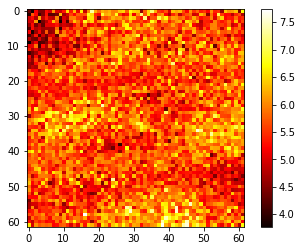

In [3]:

# on the entire state space, visualize the cost
# visualization
"""
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.set_autoscale_on(True)
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
hl, = ax.plot([], [], 'b')
#hl_real, = ax.plot([], [], 'r')
hl_for, = ax.plot([], [], 'g')
hl_back, = ax.plot([], [], 'r')
hl_for_mpnet, = ax.plot([], [], 'lightgreen')
hl_back_mpnet, = ax.plot([], [], 'salmon')

#print(obs)
def update_line(h, ax, new_data):
    new_data = wrap_angle(new_data, propagate_system)
    h.set_data(np.append(h.get_xdata(), new_data[0]), np.append(h.get_ydata(), new_data[1]))
    #h.set_xdata(np.append(h.get_xdata(), new_data[0]))
    #h.set_ydata(np.append(h.get_ydata(), new_data[1]))

def remove_last_k(h, ax, k):
    h.set_data(h.get_xdata()[:-k], h.get_ydata()[:-k])

def draw_update_line(ax):
    #ax.relim()
    #ax.autoscale_view()
    fig.canvas.draw()
    fig.canvas.flush_events()
    #plt.show()

def wrap_angle(x, system):
    circular = system.is_circular_topology()
    res = np.array(x)
    for i in range(len(x)):
        if circular[i]:
            # use our previously saved version
            res[i] = x[i] - np.floor(x[i] / (2*np.pi))*(2*np.pi)
            if res[i] > np.pi:
                res[i] = res[i] - 2*np.pi
    return res
"""
dtheta = 0.1
feasible_points = []
infeasible_points = []

imin = 0
imax = int(2*np.pi/dtheta)

dthetadot = 2.0
jmin = 0
jmax = int(12/dthetadot)


x0 = paths[pi][pj][0]
xT = paths[pi][pj][-1]
# visualize the cost on all grids

# randomly sample for several times
cost_sum_total = []
costmaps_total = []
cost_to_come_total = []
cost_to_goal_total = []
for rand_i in range(1):
    costmaps = []
    cost_to_come = []
    cost_to_goal = []
    for i in range(imin, imax):
        costmaps_i = []
        for j in range(imin, imax):
            vdot1 = random.uniform(-6., 6.)
            vdot2 = random.uniform(-6., 6.)
            x = np.array([dtheta*i-np.pi, dtheta*j-np.pi, 0., 0.])
            cost_to_come_in = np.array([np.concatenate([x0, x])])
            cost_to_come_in = torch.from_numpy(cost_to_come_in).type(torch.FloatTensor)
            cost_to_come_in = normalize(cost_to_come_in, args.world_size).cuda()
            cost_to_goal_in = np.array([np.concatenate([x, xT])])
            cost_to_goal_in = torch.from_numpy(cost_to_goal_in).type(torch.FloatTensor)
            cost_to_goal_in = normalize(cost_to_goal_in, args.world_size).cuda()
            cost_to_come.append(cost_to_come_in)
            cost_to_goal.append(cost_to_goal_in)
    cost_to_come = torch.cat(cost_to_come, 0)
    cost_to_goal = torch.cat(cost_to_goal, 0)
    obc_i_torch = torch.from_numpy(np.array([obc[pi]])).type(torch.FloatTensor).repeat(len(cost_to_goal), 1, 1, 1).cuda()
    cost_sum = mpnet(cost_to_come, obc_i_torch) + mpnet(cost_to_goal, obc_i_torch)
    cost_to_come_val = mpnet(cost_to_come, obc_i_torch).cpu().detach().numpy()[:,0]
    cost_to_goal_val = mpnet(cost_to_goal, obc_i_torch).cpu().detach().numpy()[:,0]
    cost_sum = cost_sum[:,0].cpu().detach().numpy()
    cost_sum_2d = cost_sum.reshape(imax-imin,imax-imin)
    for i in range(imin, imax):
        costmaps_i = []
        for j in range(imin, imax):
            costmaps_i.append(cost_sum_2d[i][j])
        costmaps.append(costmaps_i)
    costmaps = np.array(costmaps)

    #cost_to_come_val = cost_to_come_val
    #cost_to_goal_val = cost_to_goal_val
    
    cost_sum_total.append(cost_sum)
    costmaps_total.append(costmaps)
    cost_to_come_total.append(cost_to_come_val)
    cost_to_goal_total.append(cost_to_goal_val)
    
cost_sum_total = np.array(cost_sum_total).min(0)
costmaps_total = np.array(costmaps_total).min(0)
cost_to_come_total = np.array(cost_to_come_total).min(0)
cost_to_goal_total = np.array(cost_to_goal_total).min(0)
    
    
cost_sum = cost_sum_total
costmaps = costmaps_total
cost_to_come_val = cost_to_come_total
cost_To_goal_val = cost_to_goal_total
# plot the costmap
print(costmaps)
print(costmaps.min())
print(costmaps.max())
#costmaps = costmaps - costmaps.min() + 1.0 # map to 1.0 to infty
#costmaps = np.log(costmaps)


im = plt.imshow(costmaps, cmap='hot', interpolation='nearest')



all_points = []
for i in range(imin, imax):
    for j in range(imin, imax):
        x = np.array([dtheta*i-np.pi, dtheta*j-np.pi, 0., 0.])
        all_points.append(x)
        if IsInCollision(x, obs_i):
            infeasible_points.append(x)
        else:
            feasible_points.append(x)
all_points = np.array(all_points)
feasible_points = np.array(feasible_points)
infeasible_points = np.array(infeasible_points)
#print('feasible points')
#print(feasible_points)
#print('infeasible points')
#print(infeasible_points)
#ax.scatter(feasible_points[:,0], feasible_points[:,1], c='yellow')
#ax.scatter(infeasible_points[:,0], infeasible_points[:,1], c='pink')
#for i in range(len(data)):
#    update_line(hl, ax, data[i])
#draw_update_line(ax)
#state_t = start_state


plt.colorbar(im)
plt.show()



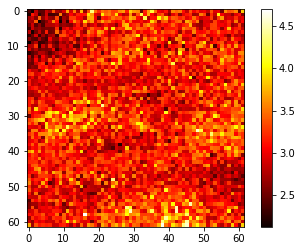

In [4]:
amplified_costmaps = np.exp(costmaps/5)
im = plt.imshow(amplified_costmaps, cmap='hot', interpolation='nearest')


plt.colorbar(im)
plt.show()


In [5]:
print(costmaps.shape)

(62, 62)


In [6]:
# propagate data
p_start = paths[pi][pj][0]
detail_paths = [p_start]
detail_controls = []
detail_costs = []
state = [p_start]
control = []
cost = []
for k in range(len(controls[pi][pj])):
    #state_i.append(len(detail_paths)-1)
    max_steps = int(costs[pi][pj][k]/step_sz)
    accum_cost = 0.
    #print('p_start:')
    #print(p_start)
    #print('data:')
    #print(paths[i][j][k])
    # modify it because of small difference between data and actual propagation
    p_start = paths[pi][pj][k]
    state[-1] = paths[pi][pj][k]
    for step in range(1,max_steps+1):
        p_start = dynamics(p_start, controls[pi][pj][k], step_sz)
        p_start = enforce_bounds(p_start)
        detail_paths.append(p_start)
        detail_controls.append(controls[pi][pj])
        detail_costs.append(step_sz)
        accum_cost += step_sz
        if (step % 1 == 0) or (step == max_steps):
            state.append(p_start)
            #print('control')
            #print(controls[i][j])
            control.append(controls[pi][pj][k])
            cost.append(accum_cost)
            accum_cost = 0.
#print('p_start:')
#print(p_start)
#print('data:')
#print(paths[i][j][-1])
state[-1] = paths[pi][pj][-1]
data = state
# end of propagation
data = np.array(data)

(3844,)
(3844,)


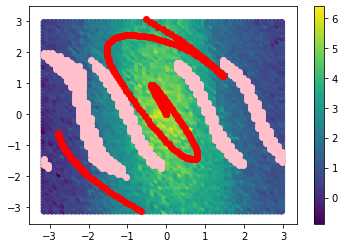

In [7]:
#ax.scatter(feasible_points[:,0], feasible_points[:,1], c='yellow')
print(all_points[:,0].shape)
print(all_points[:,1].shape)
cost_scat = plt.scatter(all_points[:,0], all_points[:,1], c=cost_to_goal_val)
plt.colorbar(cost_scat)
plt.scatter(infeasible_points[:,0], infeasible_points[:,1], c='pink')

plt.scatter(data[:,0], data[:,1], c='red')
plt.show()

(3844,)
(3844,)


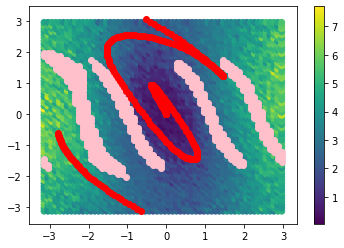

In [8]:
#ax.scatter(feasible_points[:,0], feasible_points[:,1], c='yellow')
print(all_points[:,0].shape)
print(all_points[:,1].shape)
cost_scat = plt.scatter(all_points[:,0], all_points[:,1], c=cost_to_come_val)
plt.colorbar(cost_scat)
plt.scatter(infeasible_points[:,0], infeasible_points[:,1], c='pink')

plt.scatter(data[:,0], data[:,1], c='red')
plt.show()

(3844,)
(3844,)


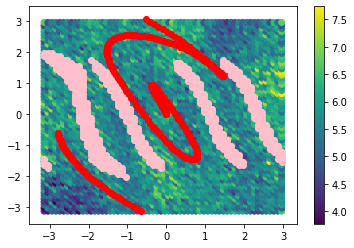

In [9]:
#ax.scatter(feasible_points[:,0], feasible_points[:,1], c='yellow')
print(all_points[:,0].shape)
print(all_points[:,1].shape)
cost_scat = plt.scatter(all_points[:,0], all_points[:,1], c=cost_sum)
plt.colorbar(cost_scat)
plt.scatter(infeasible_points[:,0], infeasible_points[:,1], c='pink')

plt.scatter(data[:,0], data[:,1], c='red')
plt.show()

(3844,)
(3844,)


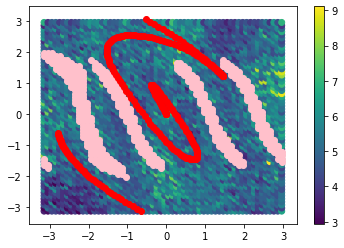

In [10]:
#ax.scatter(feasible_points[:,0], feasible_points[:,1], c='yellow')
amplified_cost_sum = np.exp(cost_sum/3.5)
print(all_points[:,0].shape)
print(all_points[:,1].shape)
cost_scat = plt.scatter(all_points[:,0], all_points[:,1], c=amplified_cost_sum)
plt.colorbar(cost_scat)
plt.scatter(infeasible_points[:,0], infeasible_points[:,1], c='pink')

plt.scatter(data[:,0], data[:,1], c='red')
plt.show()

In [16]:
data_cost_to_come = []
data_cost_to_goal = []
for i in range(len(data)):
    data_cost_to_come_i = np.array([np.concatenate([x0, data[i]])])
    data_cost_to_come_i = torch.from_numpy(data_cost_to_come_i).type(torch.FloatTensor)
    data_cost_to_come_i = normalize(data_cost_to_come_i, args.world_size).cuda()
    data_cost_to_goal_i = np.array([np.concatenate([data[i], xT])])
    data_cost_to_goal_i = torch.from_numpy(data_cost_to_goal_i).type(torch.FloatTensor)
    data_cost_to_goal_i = normalize(data_cost_to_goal_i, args.world_size).cuda()
    data_cost_to_come.append(data_cost_to_come_i)
    data_cost_to_goal.append(data_cost_to_goal_i)
data_cost_to_come = torch.cat(data_cost_to_come, 0)
data_cost_to_goal = torch.cat(data_cost_to_goal, 0)
obc_i_torch = torch.from_numpy(np.array([obc[pi]])).type(torch.FloatTensor).repeat(len(data_cost_to_come), 1, 1, 1).cuda()
data_cost_sum = mpnet(data_cost_to_come, obc_i_torch) + mpnet(data_cost_to_goal, obc_i_torch)
data_cost_to_come_val = mpnet(data_cost_to_come, obc_i_torch).cpu().detach().numpy()[:,0]
data_cost_to_goal_val = mpnet(data_cost_to_goal, obc_i_torch).cpu().detach().numpy()[:,0]
data_cost_sum = data_cost_sum[:,0].cpu().detach().numpy()
data_cost = np.cumsum(cost)




In [17]:
print("predicted cost_to_come:")
print(data_cost_to_come_val)
print("true cost_to_come:")
print(data_cost)

print("predicted cost_to_goal:")
print(data_cost_to_goal_val)
print("true cost_to_goal:")
print(np.sum(cost)-data_cost)


print("predicted added cost:")
print(data_cost_sum)
print("true added cost:")
print(np.sum(cost))


predicted cost_to_come:
[0.6262453  0.43244442 0.301592   0.32118276 0.5858098  0.54112685
 0.58503115 0.45006803 0.5817464  0.7250617  0.3858574  0.32517144
 0.47690803 0.54365885 0.65720946 0.32051966 0.67837596 0.7785531
 0.5601473  0.83105266 0.61824393 0.46428305 0.47686648 0.638952
 0.63070226 0.49277306 0.4946097  0.8356322  0.5746082  0.6713602
 0.73830485 0.34377006 0.6891142  0.47738722 0.7218156  0.7701695
 0.89260536 0.8661108  0.648944   0.57007205 0.5575176  0.8556057
 0.77286553 1.0149406  0.5501621  0.8645885  0.80269325 0.39119503
 0.814323   0.6550659  0.8483442  0.7161571  0.76664346 0.7575351
 1.1031529  0.7875992  0.67991    0.828629   0.61773133 0.8565649
 0.84431434 0.68850493 1.065331   0.8329412  1.0853302  0.7359011
 1.1146015  0.9695419  0.8539138  0.9329201  1.1393183  0.9130111
 0.97362304 0.6865808  1.2107235  1.0584606  0.99313545 1.1565958
 1.1969423  1.3493322  0.8971458  1.4626892  1.5409144  1.5202167
 1.3645171  1.5306855  1.6776991  1.4936339  1.184

In [19]:
print("predicted cost_to_come loss:")
print(np.mean(np.abs(data_cost_to_come_val[1:] - data_cost)))
print("predicted cost_to_come loss:")
print(np.mean(np.abs(data_cost_to_goal_val[1:] - np.sum(cost) + data_cost)))
print("predicted cost_sum loss:")
print(np.mean(np.abs(data_cost_sum[1:] - np.sum(cost))))



predicted cost_to_come loss:
0.30409983212859537
predicted cost_to_come loss:
0.2895668482250636
predicted cost_sum loss:
0.36057526
